In [6]:
import cv2
import os
import numpy as np
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


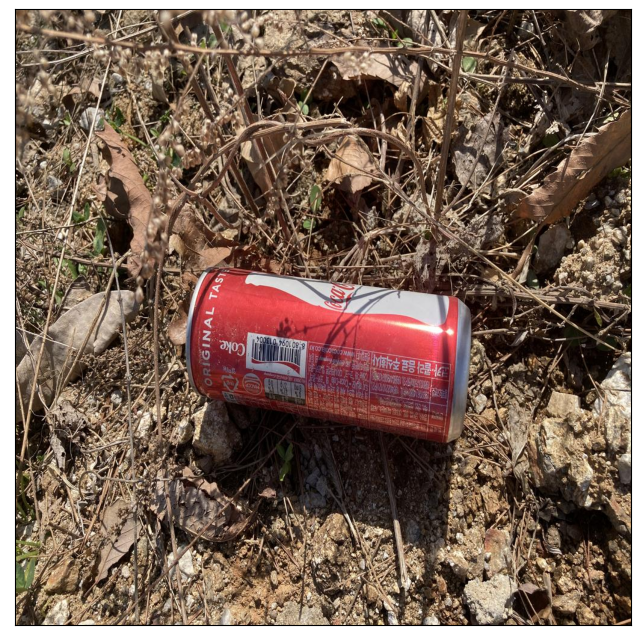

In [23]:
data_dir = '/opt/ml/dataset/'
GT_JSON = '/opt/ml/dataset/train.json'

coco = COCO(GT_JSON)

img_id = coco.getImgIds(imgIds=59)
img_info = coco.loadImgs(img_id)[0]

img = cv2.imread(os.path.join(data_dir, img_info['file_name']))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img /= 255.0

plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(img)
# plt.show()

In [8]:
img_id = coco.getImgIds(imgIds=59)
img_info = coco.loadImgs(img_id)[0]
pprint(img_info)
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Strofoam", "Plastic bag", "Battery", "Clothing")

annotation_id = coco.getAnnIds(imgIds=img_info['id'])
print(annotation_id)

{'coco_url': None,
 'date_captured': '2021-03-30 14:54:46',
 'file_name': 'train/0059.jpg',
 'flickr_url': None,
 'height': 1024,
 'id': 59,
 'license': 0,
 'width': 1024}
[288]


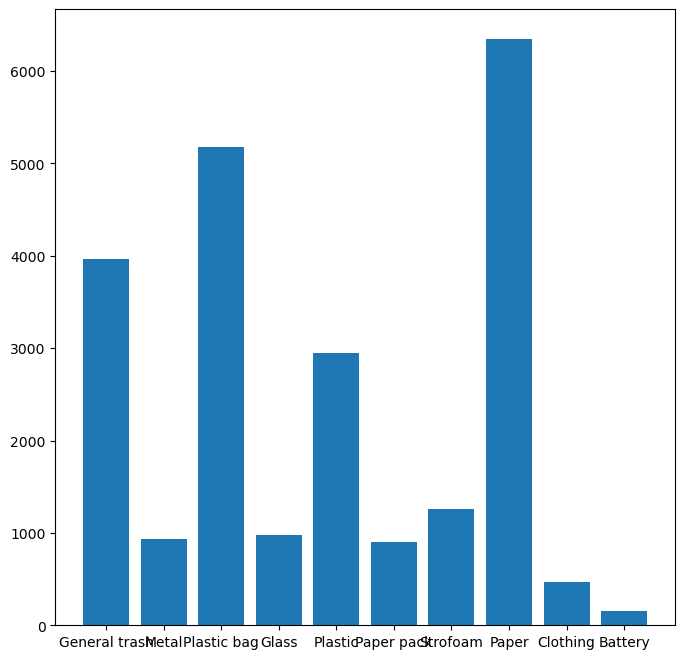

In [9]:
categories = classes

def id2cname(c_id):
    # return categories[c_id]['name']
    return categories[c_id]

# annotation_id = coco.getAnnIds(imgIds=img_info['id'])
# annotation_info_list = coco.loadAnns(annotation_id)
# pprint(annotation_info_list)
# ids = [id2cname(ann['category_id']) for ann in coco.loadAnns()]

ids = []
for annotation_id in coco.getAnnIds():
    annotation_info_list = coco.loadAnns(annotation_id)[0]
    name = id2cname(annotation_info_list['category_id'])
    ids.append(name)

counts = Counter(ids)
# pprint(counts)

plt.figure(figsize=(8,8))
plt.bar(counts.keys(), counts.values())
plt.show()

In [10]:
def id2objnum(ann):
    return len(coco.getAnnIds(imgids=ann['id']))

count = [0] * len(coco.getImgIds())
for annotation_id in coco.getAnnIds():
    annotation_info_list = coco.loadAnns(annotation_id)[0]
    # pprint(annotation_info_list)

print(len(coco.getAnnIds()))
  

# counts = Counter(ids)
# pprint(counts)

# plt.figure(figsize=(8,8))
# plt.bar(counts.keys(), counts.values())
# plt.show()

# img_id = coco.getImgIds(imgIds=59)
# img_info = coco.loadImgs(img_id)[0]
# pprint(img_info)
# classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
#            "Plastic", "Strofoam", "Plastic bag", "Battery", "Clothing")

# annotation_id = coco.getAnnIds(imgIds=img_info['id'])
# print(annotation_id)

23144


In [ ]:
4882

In [11]:
# 모듈 import

from mmcv import Config
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.utils import get_device

/opt/conda/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [20]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('../faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py')

root='/opt/ml/dataset/'

# dataset config 수정
cfg.data.train.classes = classes
cfg.data.train.img_prefix = root
cfg.data.train.ann_file = root + 'train.json' # train json 정보
cfg.data.train.pipeline[2]['img_scale'] = (512,512) # Resize

cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json' # test json 정보
cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize

cfg.data.samples_per_gpu = 4

cfg.seed = 2022
cfg.gpu_ids = [0]
cfg.work_dir = './work_dirs/faster_rcnn_r50_fpn_1x_trash'

cfg.model.roi_head.bbox_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.checkpoint_config = dict(max_keep_ckpts=3, interval=1)
cfg.device = get_device()

In [21]:
# build_dataset
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [22]:
# dataset 확인
datasets[0]


CocoDataset Train dataset with number of images 4883, and instance counts: 
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+
| category          | count | category      | count | category        | count | category    | count | category     | count |
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+
| 0 [General trash] | 3965  | 1 [Paper]     | 6352  | 2 [Paper pack]  | 897   | 3 [Metal]   | 936   | 4 [Glass]    | 982   |
| 5 [Plastic]       | 2943  | 6 [Styrofoam] | 1263  | 7 [Plastic bag] | 5178  | 8 [Battery] | 159   | 9 [Clothing] | 468   |
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+

In [19]:
# 모델 build 및 pretrained network 불러오기
model = build_detector(cfg.model)
model.init_weights()

2022-11-21 16:48:33,247 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2022-11-21 16:48:33,248 - mmcv - INFO - load model from: torchvision://resnet50
2022-11-21 16:48:33,249 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
2022-11-21 16:48:33,460 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-11-21 16:48:33,484 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-11-21 16:48:33,511 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2022-11-21 16:48:33,520 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'distribution': 'uniform', 'override'

In [14]:
# 모델 학습
train_detector(model, datasets[0], cfg, distributed=False, validate=False)

2022-10-25 17:33:46,149 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-25 17:33:46,153 - mmdet - INFO - Start running, host: root@boostcamp004-teacher006, work_dir: /home/baseline/mmdetection2/work_dirs/faster_rcnn_r50_fpn_1x_trash
2022-10-25 17:33:46,154 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
 -------------------- 
after_train_iter:
(ABOVE_NORMAL) OptimizerHook                  

KeyboardInterrupt: 